# Case study of Disney box office success using linear regression models
Walt Disney Studios has released approximately 600 films in a variety of genres since the 1930s. While there are films aimed specifically toward children, many others are meant for a wider audience.<br>
We will examine a dataset of Disney films in this notebook and examine the factors that lead to their popularity.

In [46]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np

## Loading the dataset

First, let's load the file and examine the data.

In [47]:
gross = pd.read_csv("datasets/disney_movies_total_gross.csv", 
                    parse_dates=["release_date"])

gross.head()

,movie_title,release_date,genre,mpaa_rating,total_gross,inflation_adjusted_gross
0,Snow White and the Seven Dwarfs,1937-12-21,Musical,G,184925485,5228953251
1,Pinocchio,1940-02-09,Adventure,G,84300000,2188229052
2,Fantasia,1940-11-13,Musical,G,83320000,2187090808
3,Song of the South,1946-11-12,Adventure,G,65000000,1078510579
4,Cinderella,1950-02-15,Drama,G,85000000,920608730


## Top ten movies
Let's check the top ten Disney movies who have earned the most at the box office by sorting the data by the adjusted gross in descending order.

In [48]:
inflation_adjusted_gross_desc=gross.sort_values(by='inflation_adjusted_gross',
                                                ascending=False)
print("The top 10 movies by box office earnings are :")
inflation_adjusted_gross_desc.head(10)

The top 10 movies by box office earnings are :


,movie_title,release_date,genre,mpaa_rating,total_gross,inflation_adjusted_gross
0,Snow White and the Seven Dwarfs,1937-12-21,Musical,G,184925485,5228953251
1,Pinocchio,1940-02-09,Adventure,G,84300000,2188229052
2,Fantasia,1940-11-13,Musical,G,83320000,2187090808
8,101 Dalmatians,1961-01-25,Comedy,G,153000000,1362870985
6,Lady and the Tramp,1955-06-22,Drama,G,93600000,1236035515
3,Song of the South,1946-11-12,Adventure,G,65000000,1078510579
564,Star Wars Ep. VII: The Force Awakens,2015-12-18,Adventure,PG-13,936662225,936662225
4,Cinderella,1950-02-15,Drama,G,85000000,920608730
13,The Jungle Book,1967-10-18,Musical,Not Rated,141843000,789612346
179,The Lion King,1994-06-15,Adventure,G,422780140,761640898


## Movie popularity

In the previous table, we can see that some movie genres are recurring more than others. Let's see what genres are gaining popularity : We will extract the year from ```release_year``` and store it in a new column, compute the mean of adjusted gross per genre and per year, convert the result to a DataFrame then inspect it.<br>
Then, we can plot these means to better see how box office revenues have changed over time.

,genre,release_year,total_gross,inflation_adjusted_gross
0,Action,1981,0.0,0.0
1,Action,1982,26918576.0,77184895.0
2,Action,1988,17577696.0,36053517.0
3,Action,1990,59249588.5,118358772.0
4,Action,1991,28924936.5,57918572.5
5,Action,1992,29028000.0,58965304.0
6,Action,1993,21943553.5,44682157.0
7,Action,1994,19180582.0,39545796.0
8,Action,1995,63037553.5,122162426.5
9,Action,1996,135281096.0,257755262.5


Text(0.5, 0.98, 'Genre Popularity Trend')

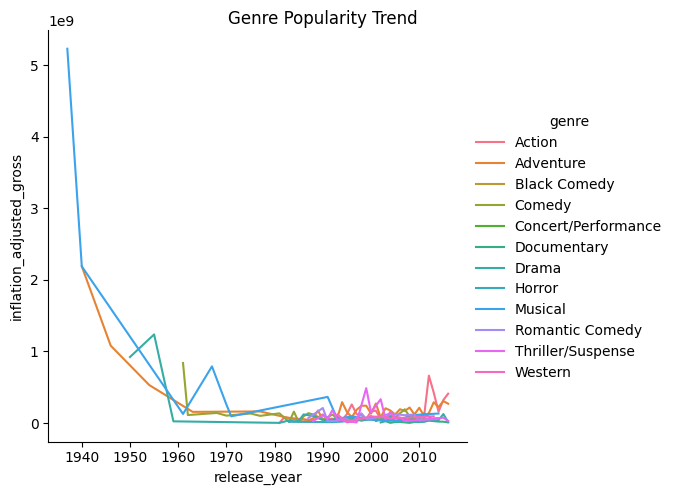

In [49]:
gross['release_year'] = pd.DatetimeIndex(gross["release_date"]).year
gross2=gross[['genre','release_year','total_gross','inflation_adjusted_gross']]
group = gross2.groupby(['genre','release_year']).mean()
genre_yearly = group.reset_index()
display(genre_yearly.head(10))

plot = sns.relplot(x='release_year', y='inflation_adjusted_gross', kind='line', hue='genre', data=genre_yearly)
plot.fig.suptitle('Genre Popularity Trend')

## One-hot encoding

Linear regression requires numerical variables, and the genre variable is categorical, so we'll have to use one-hot encoding for the conversion. For each genre except the Action genre (baseline), we'll have 11 dummy variables.<br>
Dummy variables are a clever way to convey categorical information as binary, much like writing a number in base 2, except the base here is the genres.

In [50]:
genre_dummies=pd.get_dummies(data=gross['genre'], drop_first=True).astype(int);
genre_dummies.head()


,Adventure,Black Comedy,Comedy,Concert/Performance,Documentary,Drama,Horror,Musical,Romantic Comedy,Thriller/Suspense,Western
0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0


## Genre effect

Now, we can build our linear regression model to predict the adjusted gross using these dummy variables.

By looking at the coefficient given in units of box office gross dollars from the linear regression model, we can check the effect of each genre. We'll fit our model to the dataset then get the estimated intercept and coefficient values of the effect of action and adventure genres.

In [51]:
regr=LinearRegression()
regr.fit(genre_dummies, gross["inflation_adjusted_gross"])
action=regr.intercept_
adventure=regr.coef_[[0]][0]
print("The estimated intercept and coefficient values are : \n",(action,adventure))

The estimated intercept and coefficient values are : 
 (102921757.3684211, 87475654.70909882)


## Regression parameters' confidence intervals (I)

The 95% confidence intervals for the intercept a and coefficient bi means that the intervals have a probability of 95% to contain the true value a and coefficient bi respectively. If there is a significant relationship between a given genre and the adjusted gross, the confidence interval of its coefficient should exclude 0.<br>
We will calculate the confidence intervals using the pairs bootstrap method. Then, we will perform PB estimates for the regression parameters. Note that we will draw a sample from a set of (genre, adjusted gross) data where the genre is the original genre variable. We will perform one-hot encoding after that.

In [52]:
inds=np.arange(len(gross['genre']))
size=500
bs_action_reps=np.empty(size)
bs_adventure_reps=np.empty(size)
for i in range(size) :
    bs_inds=np.random.choice(inds, size=len(inds))
    bs_genre=gross['genre'][bs_inds]
    bs_gross=gross['inflation_adjusted_gross'][bs_inds]
    bs_dummies=pd.get_dummies(data=gross['genre'], drop_first=True)
    regr=LinearRegression().fit(bs_dummies, bs_gross)
    bs_action_reps[i]=regr.intercept_
    bs_adventure_reps[i]=regr.coef_[[0]][0]

## Regression parameters' confidence intervals (II)

Finally, we compute 95% confidence intervals for the intercept and coefficient and examine if they exclude 0. If one of them (or both) does, then it is unlikely that the value is 0 and we can conclude that there is a significant relationship between that genre and the adjusted gross.

In [53]:
confidence_interval_action=np.percentile(bs_action_reps, [2.5, 97.5])
confidence_interval_adventure=np.percentile(bs_adventure_reps, [2.5, 97.5])
print("The confidence interval for the intercept is : \n",confidence_interval_action)
print("The confidence interval for the coefficient is : \n",confidence_interval_adventure)

The confidence interval for the intercept is : 
 [7.46649031e+07 2.17726085e+08]
The confidence interval for the coefficient is : 
 [-1.05043803e+08  8.17526761e+07]


## Should Disney make more action and adventure movies ?
Since the lower and upper boundaries of both confidence intervals are positive, the confidence intervals derived using the bootstrap approach for the intercept and coefficient do not contain the value zero. These indicate that there is probably a strong correlation between the action and adventure genres and the adjusted gross.

Based on our data and the findings of the bootstrap analysis and trend plot previously conducted, we can conclude that Disney films with action and adventure-themed narratives typically perform better than other genres in terms of adjusted gross.